# Micrograd

Micrograd is a small library made by Andrej Karpathy. This is a reimplementation made by me.
I wanted to have a version of Micrograd with a ton of documentation after watching the amazing
video made possible by Adrej that [you can view here](https://www.youtube.com/watch?v=VMj-3S1tku0).

The code is licensed under the MIT license and you can use it for whatever you want.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

# We have to create a datastructure (The Engine)

Creating a new datastructure so our life is easier.

In [2]:
class Tensor:
    def __init__(self, value):
        # Create a constructor for the datastructure
        self.value = value

We are going to add a bit more. We are going to make it able to add between the Tensor type and a constant

In [3]:
class Tensor:
    def __init__(self, value):
        # Create a constructor for the datastructure
        self.value = value
    def __add__(self, other): 
        # self + other
        return Tensor(self.value + other.value)

That seems like enough for now. Now we should check what is a gradient.

The gradient is a small step forward in the direction of our derivative.

But we should have a way to store this information. So we should add this to our class.

In [4]:
class Tensor:
    def __init__(self, value):
        # Create a constructor for the datastructure
        self.value = value
        self.grad = 0.0

And now that we have the possiblity to have a gradient, we should look back at what calculus is.

# Looking at you Calculus!

So we need can look at the definition of a derivative

$$x = \lim_{\Delta x \rightarrow 0} \frac{f(a+\Delta x)-f(a)}{\Delta x}$$

This did not tell me anything at first. So let's do an example.

For example. If we have a value $a = 3.0$ and a value $b=0.5$ we can get their derivatives with respect to each other.

So we can see the derivatives with respect to each other if we add them. We are going to name the result of this operation $c$

$$c = a+b$$

And now we can get the derivative with respect to $a$ and the derivative with respect to $b$.

So we are going to do a _limit_. This might seem scary but what the thing above is telling us is just to add a really small amount to see if it works.

So we are going to say: $\Delta x = 0.0001$

We have our $c1$ that is the value of $3.5$ and we increment the value of a by $0.0001$ so we get $c2 = 3.0001 + 0.5 = 3.5001$ and we can evaluate this value in
the derivative:

$$\frac{c2-c1}{\Delta x} = \frac{ 3.5001-3.5}{0.0001} = \frac{0.0001}{0.0001} = 1$$

Now we can do the same but for other operations

In [5]:
a = 3.0
b = 1.5
h = 0.0001

c1 = a*b
c1

4.5

We can see the difference in the slope by going through the same process we did with the adition.

In [6]:
a += h
b = 1.5

c2 = a*b
derivative = (c2-c1)/h
derivative

1.500000000005386

And for the derivative of b with respect to a we can see the following.

In [7]:
a = 3.0
b = 1.5
h = 0.0001

c1 = a*b
b += h
c2 = a*b

(c2-c1)/h

3.00000000000189

We can see that the values of the derivatives for $a$ and $b$ swap in the derivative. 
So we can modify our Tensor class to store the gradients of this operations.

# The Full Engine

In [8]:
class Tensor:
    """
        Stores a single value.
    """
    def __init__(self, value, _children=(), _operation=""):
        # Create a constructor for the datastructure
        self.value = value
        self.gradient = 0.0
        
        # Internal variables
        self._prev = set(_children)
        self._backward = lambda: None
        
        # Debugging
        self._operation = _operation
        
    def __add__(self, other):
        # self + other
        other = other if isinstance(other, Tensor) else Tensor(other)
        output = Tensor(self.value + other.value, (self, other), '+')
        
        def _backward():
            self.gradient += output.gradient
            other.gradient += output.gradient
        output._backward = _backward
        
        return output
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        # self * other
        other = other if isinstance(other, Tensor) else Tensor(other)
        output = Tensor(self.value * other.value, (self, other), '*')
        
        def _backward():
            # we use the chain rule so that is why we multiply out.gradient * self and out.grad * other.value
            self.gradient += other.value * output.gradient
            other.gradient += self.value * output.gradient
        output._backward = _backward
        
        return output
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        # self ** other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        output = Tensor(self.value ** other, (self,), '^')
        
        def _backward():
            self.gradient += (other*self.value ** (other-1))*output.gradient
        
        output._backward = _backward
        
        return output
    
    def backward(self):
        # Topological order of the children in the graph
        # Using the dfs version of topological sort
        topological_order = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topological_order.append(v)
        
        build_topo(self)
        
        self.gradient = 1.0
        
        for v in reversed(topological_order):
            v._backward()
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __repr__(self):
        # This function returns the value formatted when you print it in jupyterlab
        return f"Tensor=({self.value}, gradient={self.gradient})"
    
    # Extra
    def tanh(self):
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Tensor(t, (self, ), 'tanh')

        def _backward(): 
            self.gradient += (1 - t**2) * out.gradient
        
        out._backward = _backward
        
        return out

# The nn

In [12]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.gradient = 0
    def parameters(self):
        return []

In [13]:
class Neuron:
    """ Class Neuron inherits from Module """
    
    def __init__(self, nin):
        # Initialize number in neuron
        # Nin --> Number of inputs
        self.w = [Tensor(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Tensor(0)
    
    def __call__(self, x):
        # w * x +b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [14]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
            
        return params

In [15]:
class MLP:
    """
        Multi-Layer Perceptron
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# An example

In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Tensor=(-0.1287955604443376, gradient=0.0)

In [17]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Creating a metric function. In this case we use the mean squared error function

## Gradient Descent

In [18]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    
    # zero grad
    for p in n.parameters():
        p.gradient = 0.0
        
    # backward pass    
    loss.backward()
    
    # update
    for p in n.parameters():
        p.value += -0.05*p.gradient
    
    print(k, loss.value)

0 3.6461118424965435
1 2.1992116474110746
2 1.527268058818012
3 0.8253180411028479
4 0.40729347993046133
5 0.24480034340777723
6 0.17218984478699947
7 0.13184120295831725
8 0.1061546958093535
9 0.08847664212460303
10 0.07562214221526461
11 0.06588452062362513
12 0.05827078639381458
13 0.052165700093168815
14 0.047168659872599494
15 0.04300810479948695
16 0.039493711891586084
17 0.0364883006996128
18 0.033890600113030425
19 0.03162428737994592


In [19]:
ypred

[Tensor=(0.9376107822235494, gradient=-0.12477843555290113),
 Tensor=(-0.9612476093889457, gradient=0.07750478122210858),
 Tensor=(-0.88266676867396, gradient=0.23466646265208002),
 Tensor=(0.8883620228877879, gradient=-0.22327595422442426)]

We almost got the predictions we wanted! That is really cool (do not look at the concept of overfitting obiously).

# A bigger example

**TODO**: Actually make this work. I went through the demo they have in micrograd. But wanted to implement something else. So This is the general structure but it has a lot of bugs.

I wanted to use the iris dataset as a bigger example than the one given in the class. I think it is relatively simple to classify and at the same time it is really visually apparent in the way it works.

In [20]:
from sklearn import datasets

X, y = datasets.load_breast_cancer(return_X_y=True)

/mnt/data/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

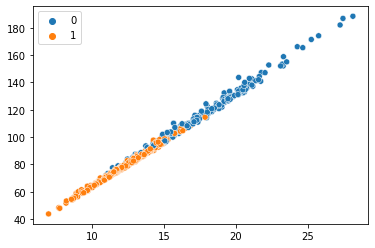

In [21]:
# TODO: Graph the data
sns.scatterplot(X[:,0], X[:,2], hue=y)

Create a Multi layer perceptron of two layers of ten neurons each and a single output.

In [22]:
model = MLP(2, [10, 10, 1])
print("Number of parameters:", len(model.parameters()))

Number of parameters: 151


In [23]:
def loss(batch_size=None):
    
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Tensor, xrow)) for xrow in Xb]
    
    # get scores
    scores = list(map(model, inputs))
    
    # We are scoring based on mse
    current_loss = sum((scorei-yi)**2 for yi, scorei in zip(yb, scores))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    
    return current_loss
current_loss = loss()
print(current_loss)

Tensor=(1062.0059237090663, gradient=0.0)


In [24]:
# Optimization
for k in range(100):
    # forward pass
    current_loss = loss()
    
    # zero grad
    for p in model.parameters():
        p.gradient = 0.0
        
    # backward pass    
    current_loss.backward()
    
    # update Stochastic Gradient descent
    learning_rate = 0.01 # maybe change to other thing later
    for p in model.parameters():
        p.value -= learning_rate*p.gradient
    
    if k%10 == 0:
        print(f"step {k} loss {current_loss.value}")

step 0 loss 1062.0059237090663
step 10 loss 212.0
step 20 loss 212.0
step 30 loss 212.0
step 40 loss 212.0
step 50 loss 212.0
step 60 loss 212.0
step 70 loss 212.0
step 80 loss 212.0
step 90 loss 212.0


In [30]:
inputs = [list(map(Tensor, xrow)) for xrow in X]

In [31]:
preds = list(map(model, inputs))

In [32]:
preds = [pred.value for pred in preds]